| Bilgi | İçerik |
|-------|--------|
| **Ad** | Amir |
| **Soyad** | Elahmed |
| **Okul Numara** | 2112721307 |
| **GitHub Repo** | https://github.com/Amirelahmed/YoloV8_Nesne_Tespiti/tree/main |


# 📌 YOLOv8 Saat / Fare Nesne Tespiti Çalışması

Bu projede, tarafımdan çekilen görüntüler kullanılarak iki sınıflı
(clock – mouse) bir nesne tespit modeli geliştirilmiştir. Veri seti
train/val olarak düzenlenmiş, etiketler YOLO formatında hazırlanmış
ve model YOLOv8s mimarisi ile eğitilmiştir.

Eğitim sırasında veri artırma (augmentation), AdamW optimizer,
60 epoch ve 640×640 çözünürlük kullanılmıştır. Eğitim tamamlandıktan
sonra elde edilen best.pt modeli, PyQt5 ile hazırlanmış bir grafik
arayüzde gerçek zamanlı görsel yükleme ve nesne tespiti amacıyla
kullanılmıştır.

Bu çalışma kapsamında:
- Görüntü etiketleme ve veri hazırlama,
- YOLOv8 ile model eğitimi,
- Tahmin sonuçlarının test edilmesi,
- Python + PyQt5 ile masaüstü GUI geliştirilmesi

başarıyla uygulanmıştır.


1. Kütüphanelerin Kurulumu

In [20]:
!pip install --upgrade ultralytics
!pip install opencv-python-headless matplotlib pyyaml

2. Dataset ZIP Yükleme ve Çıkarma


In [21]:
from google.colab import files
import zipfile, os

# Kullanıcının dataset.zip dosyasını yüklemesi
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

zip_path = f"/content/{zip_name}"
extract_path = "/content"

# ZIP çıkarma
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("✔ Dataset başarıyla çıkarıldı!")
print("📂 İçerik:", os.listdir("/content"))


Saving dataset.zip to dataset (1).zip
✔ Dataset başarıyla çıkarıldı!
📂 İçerik: ['.config', 'dataset', 'clock_010.jpeg', 'dataset (1).zip', 'D_NQ_NP_699893-MLM50866609878_072022-O.webp', 'clock_001.jpeg', 'yolo11n.pt', 'clock_002.jpeg', 'clock_010 (1).jpeg', 'data.yaml', 'dataset.zip', 'yolov8n.pt', 'OIP.jpg', 'wi1-7.webp', 'OIP (1).webp', 'runs', 'OIP.webp', 'sample_data']


3. Klasör Yapısını Kontrol Etme

In [22]:
dataset_root = "/content/dataset"

for root, dirs, files in os.walk(dataset_root):
    print(root, "->", len(files), "dosya")


/content/dataset -> 0 dosya
/content/dataset/labels -> 2 dosya
/content/dataset/labels/train -> 141 dosya
/content/dataset/labels/val -> 81 dosya
/content/dataset/images -> 0 dosya
/content/dataset/images/train -> 140 dosya
/content/dataset/images/val -> 80 dosya


4. Etiketli Görsel Önizleme (Opsiyonel)






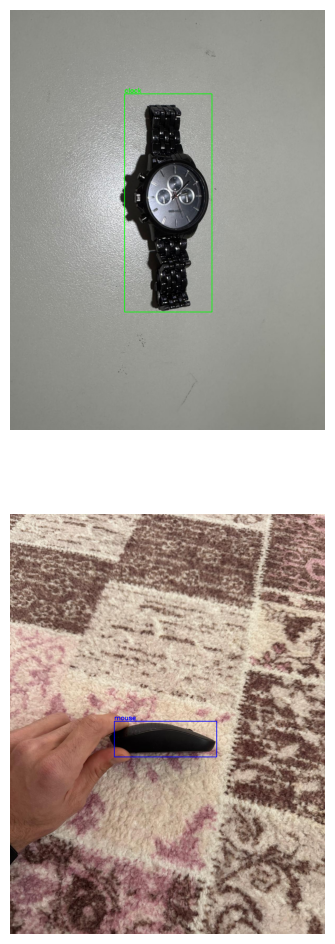

In [28]:
import cv2
import matplotlib.pyplot as plt

def show_image_with_labels(img_path, txt_path, class_names):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(txt_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, xc, yc, bw, bh = line.split()
        cls = int(cls)
        xc, yc, bw, bh = map(float, (xc, yc, bw, bh))

        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        color = (0,255,0) if cls == 0 else (255,0,0)
        label = class_names[cls]

        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# 🔥 عرض صورتين في نفس الـ output (تحت بعض)
clock_img = show_image_with_labels(
    "/content/dataset/images/train/clock_001.jpeg",
    "/content/dataset/labels/train/clock_001.txt",
    ["clock", "mouse"]
)

mouse_img = show_image_with_labels(
    "/content/dataset/images/train/mouse_001.jpeg",
    "/content/dataset/labels/train/mouse_001.txt",
    ["clock", "mouse"]
)

plt.figure(figsize=(7,12))

plt.subplot(2,1,1)
plt.imshow(clock_img)
plt.axis("off")

plt.subplot(2,1,2)
plt.imshow(mouse_img)
plt.axis("off")

plt.show()


5. data.yaml Dosyası Oluşturma

In [29]:
yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 2
names: ["clock", "mouse"]
"""

with open("/content/dataset/data.yaml", "w") as f:
    f.write(yaml_content)

print("✔ data.yaml oluşturuldu!")


✔ data.yaml oluşturuldu!


6. YOLOv8 ile Eğitim (Geliştirilmiş Ayarlar)

In [31]:
!yolo task=detect mode=train \
    model=yolov8s.pt \
    data="/content/dataset/data.yaml" \
    epochs=60 \
    imgsz=640 \
    batch=16 \
    optimizer=AdamW \
    hsv_h=0.015 \
    hsv_s=0.7 \
    hsv_v=0.4 \
    degrees=10 \
    translate=0.1 \
    scale=0.5 \
    shear=0.1 \
    mosaic=1 \
    mixup=0.2 \
    patience=20 \
    project="runs/detect" \
    name="clock_mouse_detector"


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=10, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1, multi_scale=False, name=clock_mouse_detector3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=T

7. Eğitilen Model ile Test (Düzeltildi + Hatasız)

Saving mouse_085.jpeg to mouse_085.jpeg

image 1/1 /content/mouse_085.jpeg: 640x480 1 mouse, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict17
📂 Kullanılan klasör: /content/runs/detect/predict17
📄 Gösterilen dosya: /content/runs/detect/predict17/mouse_085.jpg


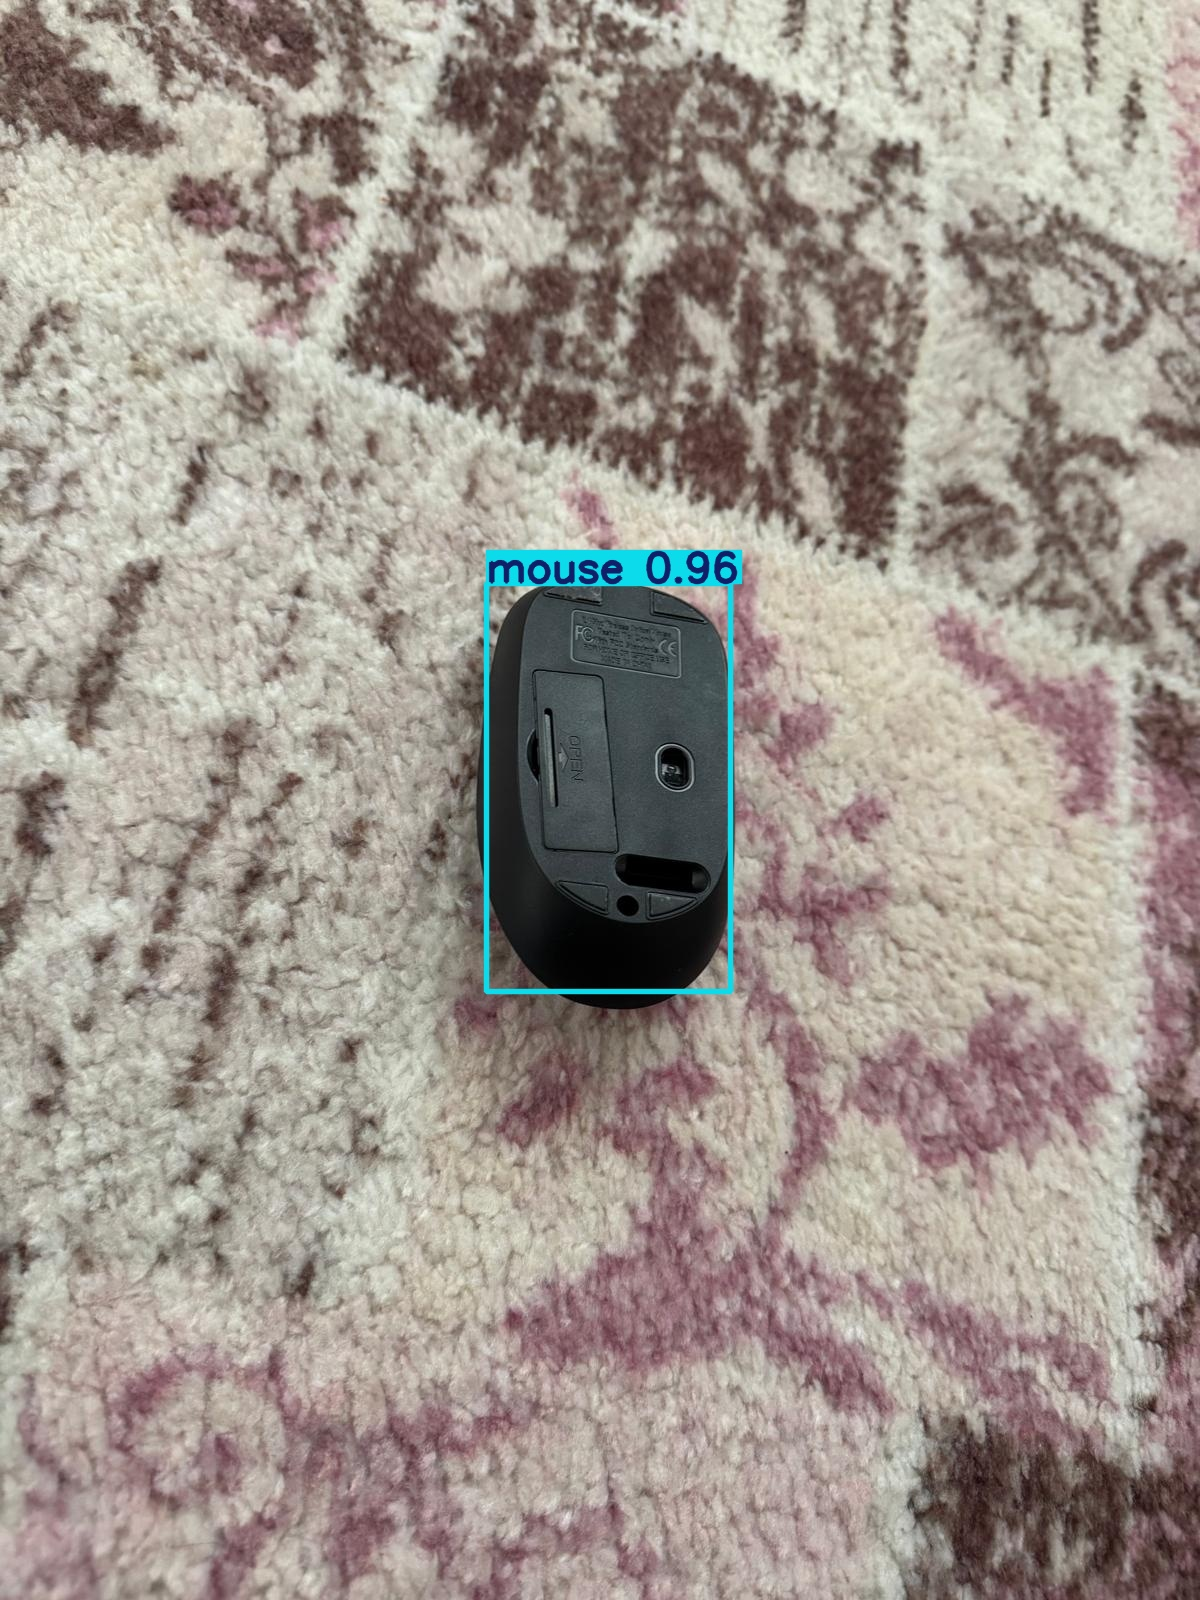

In [40]:
from google.colab import files
from ultralytics import YOLO
from IPython.display import Image, display
import os

model = YOLO("/content/runs/detect/clock_mouse_detector/weights/best.pt")

uploaded = files.upload()
test_img = list(uploaded.keys())[0]

results = model(test_img, conf=0.55, save=True)

pred_dir = results[0].save_dir
saved_files = os.listdir(pred_dir)

for f in saved_files:
    if f.lower().endswith((".jpg",".jpeg",".png",".webp")):
        pred_path = os.path.join(pred_dir, f)
        break

print("📂 Kullanılan klasör:", pred_dir)
print("📄 Gösterilen dosya:", pred_path)
display(Image(filename=pred_path))


8. best.pt İndirme

In [44]:
from google.colab import files
files.download("/content/runs/detect/clock_mouse_detector/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>